In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import urllib.request as urllib2
#from urllib.request import urlopen
import json
import re
import urllib.parse
import pickle
from fa2 import ForceAtlas2
import collections
import powerlaw
import os
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
#from nltk.stem import WordNetLemmatizer
import collections
from IPython.display import Markdown as md
import seaborn as sns
from PIL import Image

#from scipy.interpolate import interp1d
#from pathlib import Path
from wordcloud import WordCloud
from nltk.corpus import PlaintextCorpusReader as pcr
#from nltk.corpus import PlaintextCorpusReader
#from nltk.tokenize import WordPunctTokenizer
#import string
import community
from importlib import reload 
reload(community)
#from math import isnan
#import random
from fa2 import ForceAtlas2
import random
from bokeh.io import output_notebook, show
from bokeh.models import Range1d, Circle, MultiLine, NodesAndLinkedEdges
from bokeh.plotting import from_networkx
#from bokeh.palettes import Blues8
import bokeh.plotting.figure as bokeh_figure

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus
import pyLDAvis
import pyLDAvis.gensim_models
import warnings


import re
from bs4 import BeautifulSoup
#from IPython.core.display import display, HTML
import requests


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline 

C:\Users\miaha\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'vaderSentiment'

In [6]:
corpus_root = os.getcwd() + '/data/characters/'
file_list = characters_dropna['File_Name'] + '.txt'
corpus = pcr(corpus_root, file_list)

In [ ]:
def create_wordclouds(data):
    #The if statement filter the object between a corpus and a dictionary
    if type(data) == dict:
        tc_dict = {document:{term:term_count for term,term_count in FreqDist(data[document]).most_common()} for document in data.keys()}
    else:
        tc_dict = {document:{term:term_count for term,term_count in FreqDist(data.words(document)).most_common()} for document in data.fileids()}
    
    #Dictionary with IDF values for each unique word
    idf_dict = {}
    for term in set([term for i in tc_dict.keys() for term in tc_dict[i].keys()]):
        N = len(tc_dict.keys()) #Total number of words inside document
        nt = 0 
        for d in tc_dict.keys():
            if term in tc_dict[d].keys():
                nt += 1 # nt describes in how many documents the term appears
        idf_dict[term] = round(np.log(N/nt),4) #Calculate Inverse Term Frequency
    
    #Dictionary with TC-IDF values for each word for each document
    tc_idf_dict = {document:{term:tc_dict[document].get(term)*idf_dict.get(term) for term in tc_dict[document].keys()}\
         for document in tc_dict.keys()}
    
    #Dictionary with TC-IDF values of the top 200 words for each docoment
    most_common_dict = {document:{word:value for word,value in sorted(tc_idf_dict[document].items(),\
         key=lambda item: item[1],reverse=True)[:200]} for document in tc_dict.keys()}
    

    #Create wordclouds
    col_word = ['Reds', 'Purples', 'BuGn', 'Blues', 'Greens'] #Colormap
    mask = np.array(Image.open(os.getcwd() + '/data/Stormtrooper.jpg')) #Create shape image for wordclouds
    a = 0

    #Plotting the word cloud
    plt.figure(figsize=[16, 24])
    for attribute in most_common_dict.keys():
        plt.subplot(3, 2, a+1)
        wordcloud = WordCloud(mask=mask, collocations = False, background_color="white", colormap=col_word[a],\
             max_font_size=1024, relative_scaling = 0.6, max_words = 200, 
        width = 3000, height = 3000).generate_from_frequencies(most_common_dict[attribute])
        
        a+=1
        plt.imshow(wordcloud,interpolation="bilinear")
        plt.axis("off")
        attribute_clean = str(attribute).replace('.txt','')
        plt.title(f'{attribute_clean}', fontsize=30)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

# Word clouds

## Word clouds for Anakin/Darth Vader based on movies scripts

In [16]:
def first_trilogy_script(path):
    with open(path, 'r', encoding = 'utf8') as file:
        text = file.read() #Read txt file that contains the dialogue

    #Filtering
    text = re.sub(r'\\\n\\\n','\n\n',text) #some scripts have \ for every new line
    text = re.sub(r'\\\n',' ',text) # same as above
    sw = re.findall(r'(?=.*:).*(?=\n\n)',text) # a dialogue pattern is name: dialogue
    sw = [re.sub(r'\s+',' ',elem) for elem in sw] #substituting multiple whitespace with one

    names = [re.findall('(.*)(?=:)',elem)[0] for elem in sw] # find all the names pattern is name: 
    names = np.unique(names) # only getting unique names
    
    # Create df with names and their dialogues
    sw_df = pd.DataFrame(names,columns=['text'], index = names)
    for _, row in sw_df.iterrows():
        pattern = r'(?<=' + re.escape(row['text']) + r':).*(?=\n\n)' #finding character specific dialogue
        row['text'] = ' '.join(re.findall(pattern,text)) #adding it as a single string

    sw_df['clean_text'] = sw_df['text'].apply(clean_text) #adding a cleaned version 
    
    return sw_df

In [19]:
sw1_df = first_trilogy_script('data/script/Star Wars Episode I - The Phantom Menace.txt')
sw2_df = first_trilogy_script('data/script/Star Wars- Episode II - Attack of the Clones.txt')
sw3_df = first_trilogy_script('data/script/Star Wars- Episode III - Revenge of the Sith.txt')

In [20]:
# Create function that filters the dialogues
def create_df_SW_OR(path):
    dia = pd.read_csv(path, sep="\t") # the path to find the scripts
    list_char_IV = []
    list_diag_IV = []
    for _, row in dia.iterrows(): # we itterate through one dialogue/line at a time.
        text = row.iloc[0] 
        text_split = text.split('"') # splitting by " to get character and dialogue the format is "character" "dialogue"

        # Add to list the character
        list_char_IV.append(text_split[1]) # 1st element is name

        # Add to daiglog of the character
        list_diag_IV.append(''.join(text_split[3:])) # 3rd element and onwrads is dialogue

    df = pd.DataFrame({'Character': list_char_IV, 'Dialogue': list_diag_IV})
    return df

In [21]:
star_wars_IV_df = create_df_SW_OR('data/script/SW_EpisodeIV.txt')
star_wars_V_df = create_df_SW_OR('data/script/SW_EpisodeV.txt')
star_wars_VI_df = create_df_SW_OR('data/script/SW_EpisodeVI.txt')

In [22]:
# Create dataframe for each character 
def aug_df_SW(df):
    name_unqiue = set(df['Character']) #finding the unique names in our dialogue dataframe
    list_name = []
    list_dia = []
    for i in name_unqiue: 
        list_name.append(i)
        list_dia.append(clean_text(' '.join(df[df['Character'] == i]['Dialogue'].values))) # taking every row equal to the given name
        
    return pd.DataFrame({'Character': list_name, 'Dialogue': list_dia})

In [23]:
star_wars_IV_df1 = aug_df_SW(star_wars_IV_df)
star_wars_V_df1 = aug_df_SW(star_wars_V_df)
star_wars_VI_df1 = aug_df_SW(star_wars_VI_df)

In [ ]:
anakin_dict = dict(zip(('Star Wars Episode 1', 'Star Wars Episode 2', 'Star Wars Episode 3'),
                   (sw1_df["clean_text"]['ANAKIN'], 
                    sw2_df["clean_text"]['ANAKIN'], 
                    sw3_df["clean_text"]['ANAKIN'])))

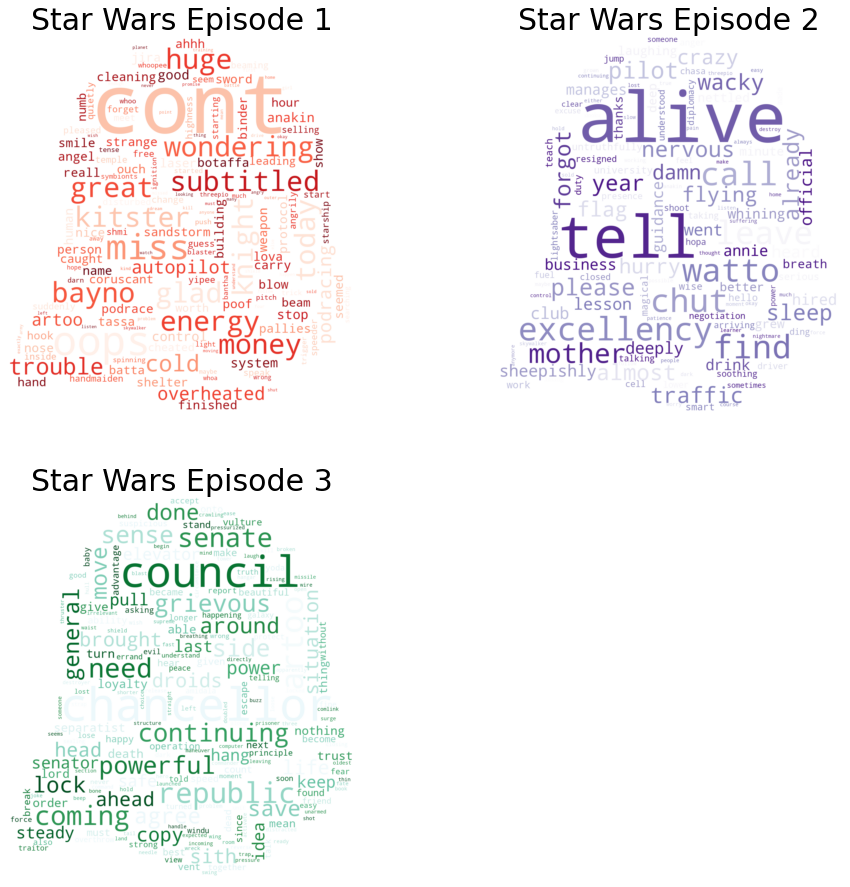

In [ ]:
create_wordclouds(anakin_dict)

We see on Anakin's word cloud from the second movie, words that describe his love for Padme such as 'alive' and 'nervous'. The word 'mom' which show us how much he misses his mother in the second movie. Also in the third movie we can see more political words such as the 'senate', 'jedi council', 'war', and 'Chancellor' (referring to Chancellor Palpatine).

In [ ]:
vader_dict = dict(zip(('Episode 4','Episode 5','Episode 6'),
                   ([word for sublist in star_wars_IV_df1['Dialogue'][star_wars_IV_df1['Character'] == 'VADER'] for word in sublist], 
                    [word for sublist in star_wars_V_df1['Dialogue'][star_wars_V_df1['Character'] == 'VADER'] for word in sublist], 
                    [word for sublist in star_wars_VI_df1['Dialogue'][star_wars_VI_df1['Character'] == 'VADER'] for word in sublist])))

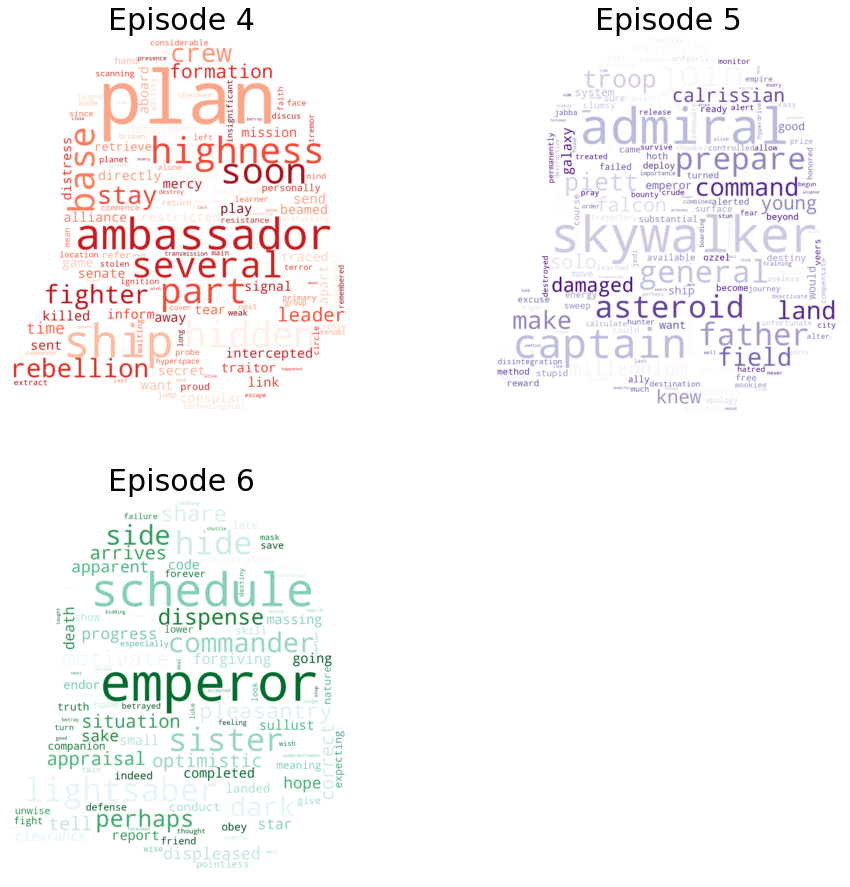

In [ ]:
create_wordclouds(vader_dict)

For the sixth movie we can see important words for the movie plot such as 'emperor', 'lightsaber', 'dark side', and 'sister'. Also on the fifth movie we observe that the word 'join' appears (from the famous sentence "join the dark side") and the most valuable word for the trilogy 'father'.

In [ ]:
#We create a list of words from Anakin's dialogue from the prequel trilogy
anakin_dialogue = sw1_df['clean_text']['ANAKIN'] + sw2_df['clean_text']['ANAKIN']+ sw3_df['clean_text']['ANAKIN']

#We create a list of words from Anakin's dialogue from the original trilogy
vader_dialogue = star_wars_IV_df1['Dialogue'][star_wars_IV_df1['Character'] == 'VADER'].values[0]\
     + star_wars_V_df1['Dialogue'][star_wars_V_df1['Character'] == 'VADER'].values[0]\
         + star_wars_VI_df1['Dialogue'][star_wars_VI_df1['Character'] == 'VADER'].values[0]

#Above we create a dictionary of both lists from above as values
anakin_vader_dict = {'Anakin Skywalker':anakin_dialogue, 'Darth Vader':vader_dialogue}

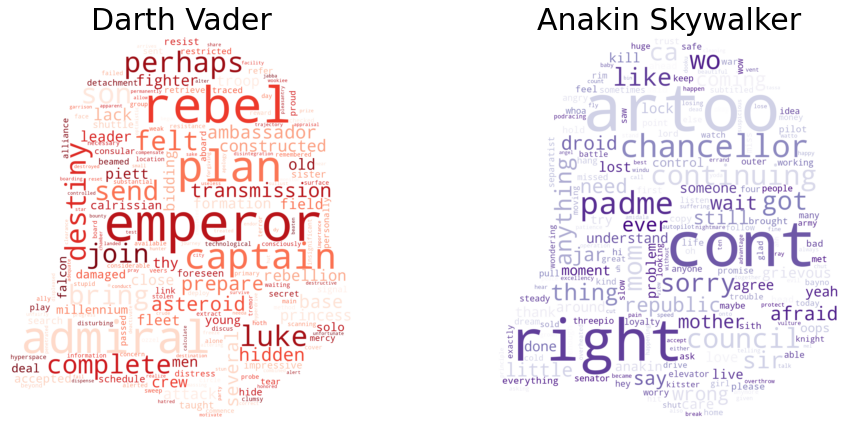

In [ ]:
create_wordclouds(anakin_vader_dict)

By comparing Anakin to Darth Vader we can see a lot of descriptive words for example 'Padme' and 'right' which stem from Anakin trying to question if what he does is right. Then words such as 'sorry' and 'mother' create a more emotional thus human aspect to the character, but for Darth Vader's word cloud there are words such as 'emperor', 'destiny', 'rebels fighter', and 'rebellion'. His descriptive words have changed a lot after his transformation to the dark side. Also the word 'Luke' appears on Darth Vader's wordcloud which is his son (spoiler alert).

## Word clouds for the two trilogies based on movies scripts

In [ ]:
#We create a list with all the dialogues from Prequel Trilogy
original_dialogue = re.split(' ',' '.join([' '.join(i) for i in sw1_df['clean_text'].values]))\
    + re.split(' ',' '.join([' '.join(i) for i in sw2_df['clean_text'].values]))\
        + re.split(' ',' '.join([' '.join(i) for i in sw3_df['clean_text'].values]))

#We create a list with all the dialogues from Original Trilogy
prequel_dialogue = re.split(' ',' '.join([' '.join(i) for i in star_wars_IV_df1['Dialogue'].values]))\
     + re.split(' ',' '.join([' '.join(i) for i in star_wars_V_df1['Dialogue'].values]))\
         + re.split(' ',' '.join([' '.join(i) for i in star_wars_VI_df1['Dialogue'].values]))

#Dictionary with the lists above as values
original_prequel_dict = {'Original Trilogy':original_dialogue, 'Prequel Trilogy':prequel_dialogue}

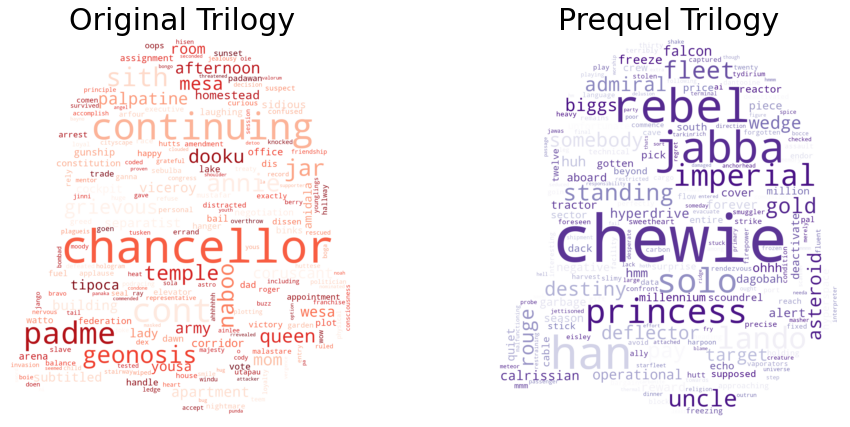

In [ ]:
create_wordclouds(original_prequel_dict)

We observe for the first wordcloud some descriptive words (of the trilogy plot) such as 'Chancellor', 'Padme', and the battle of 'Geonosis'.
For the Prequel Trilogy we observe words related to 'Han solo' and Princess 'Leia' such as 'princess', 'solo' ,'millennium' ,'Calrissian' (Known friend/allie of Han solo), 'Chewie' (his companion) and 'Jabba the Hut'.

# Sentiment analysis

### Part 3.5.1: Analysis of Wikipage
<a id='S_wiki.'></a>

Wikipages are normally written in a neutral way. The sentiment analysis is thus not suited for wikipages but for the fun of it, let's try and see what will get out of it.

For sentiment analysis we will be using LabMT and VADER. Thus, we need to get these two methods ready. First, we load the txt file for the LabMT methods and initialize VADER.

In [ ]:
# Load the LabMT data and convert to dictionary
LabMT_df = pd.read_csv('data/labMT.txt', sep="\t", header=0, skiprows=[0,1])
word_list_LabMT = LabMT_df['word'].tolist()
LabMT_dict = LabMT_df.set_index('word')['happiness_average'].to_dict()

# VADER form the vaderSentiment library
analyzer = SentimentIntensityAnalyzer()

## Load the wiki page for each character and save in a dictionary 
wiki = {}

In [ ]:
# Define function for compute LabMT sentiment for a text
def compute_avg_sentiment_LabMT(text):
    # Join all sentences to one string

    # Clean text 
    words_final = clean_text(text)
    
    # Initialization to store values
    s = 0
    n = 0

    # Using freqDist to only loop over unique words 
    fdist = FreqDist(w for w in words_final)
    word_unique = [word for word in fdist.keys()]
    word_fre = [f for f in fdist.values()]

    # Loop over words 
    for i in range(len(fdist)):
        w = word_unique[i]
        f = word_fre[i]

        # Get the LabMT score
        S_v = LabMT_dict.get(w, None)

        # Weight the socre by the frequency
        if S_v is not None:
            s += f * LabMT_dict.get(w, None)
            n += f
            
    if n == 0:
        return np.nan
    return s/n

In [ ]:
# Define function for compute sentiment for a text
def compute_avg_sentiment_VADER(text):
    if len(text) == 0:
        return 0
    
    # Convert the text file to the right format, where each line is a  new element
    text = text.split('\n')
    if len(text) == 1:
        text = [text, '']

    # Initialzation 
    s = 0
    len_VADER = 0

    # Compute polarity for each sentence in text 
    for sentence in text:
        if sentence:
            vs = analyzer.polarity_scores(sentence)
            s += vs['compound']
            len_VADER += 1
            
    # Retur the average polarity
    return s/len_VADER

## Analysis of Movie Scipts
<a id='S_script.'></a>

### Loading the scripts
The wikipages are written in a neutral way, thus we found that it may be more interesting to take a look at the movie scripts. We wish to examen if we can find time in movies, where characters are more happy or sad. We start with load the scripts. As mentioned earlier the scripts for the original trilogy and the prequal trilogy are different, thus we need to define two different functions to create a dataframe for all dialogues appearing in chronological order. First, we will define the fucntion `create_df_SW_OR` which create the dataframe based on the txt file from [github](https://github.com/kamran786/Star-Wars-Movie-Scripts-Text-Analysis).

In [ ]:
# Define function to load script of the original trilogy 
def create_df_SW_OR(path):

    # Load txt file
    dia = pd.read_csv(path, sep="\t")

    # Initilaize list for the character and dialouge 
    list_char_IV = []
    list_diag_IV = []

    # Loop over all rows in data 
    for _, row in dia.iterrows():
        text = row.iloc[0]
        text_split = text.split('"')

        # Add character speaking to list
        list_char_IV.append(text_split[1])

        # Add daiglog to list
        list_diag_IV.append(''.join(text_split[3:]))

    # Create dataframe 
    df = pd.DataFrame({'Character': list_char_IV, 'Dialogue': list_diag_IV})
    df['Sentiment_LabMT'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_LabMT(x))
    df['Sentiment_VADER'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_VADER(x))
    return df

In [ ]:
def create_df_SW_PREQUAL(path):

    # Open file 
    with open(path, 'r', encoding = 'utf8') as file:
        text = file.read()
    
    # remove newlines 
    text = re.sub(r'\\\n\\\n','\n\n',text)
    text = re.sub(r'\\\n',' ',text)
    text = re.sub(r'\(.*\)', '', text)

    # Finding the correct format for the dialogues
    sw1 = re.findall(r'(?=.*:).*(?=\n\n)',text)
    sw1 = [re.sub(r'\s+',' ',elem) for elem in sw1]

    # Loop through all dialogues and add the speaking character and dialogue
    list_char = []
    list_dia = []
    for row in sw1:
        split_text = row.split(':')
        list_char.append(split_text[0])
        list_dia.append(' '.join(split_text[1:]))
    
    # Create dataframe and compute sentiment 
    df = pd.DataFrame({'Character' : list_char, 'Dialogue' : list_dia})
    df['Sentiment_LabMT'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_LabMT(x))
    df['Sentiment_VADER'] = df['Dialogue'].apply(lambda x: compute_avg_sentiment_VADER(x))

    return df

In [ ]:
# Load the script for the original trilogy
star_wars_IV_df = create_df_SW_OR('data/script/SW_EpisodeIV.txt')
star_wars_V_df = create_df_SW_OR('data/script/SW_EpisodeV.txt')
star_wars_VI_df = create_df_SW_OR('data/script/SW_EpisodeVI.txt')

# Load the scripts for the prequals 
star_wars_I_df = create_df_SW_PREQUAL('data/script/Star Wars Episode I - The Phantom Menace.txt')
star_wars_II_df = create_df_SW_PREQUAL('data/script/Star Wars- Episode II - Attack of the Clones.txt')
star_wars_III_df = create_df_SW_PREQUAL('data/script/Star Wars- Episode III - Revenge of the Sith.txt')

In [ ]:
star_wars_V_df.head()

,Character,Dialogue,Sentiment_LabMT,Sentiment_VADER
0,LUKE,"Echo Three to Echo Seven. Han, old buddy, do y...",6.103333,0.0000
1,HAN,"Loud and clear, kid. What's up?",5.320000,0.3818
2,LUKE,"Well, I finished my circle. I don't pick up an...",6.456667,0.2732
3,HAN,There isn't enough life on this ice cube to fi...,5.732500,0.0000
4,LUKE,Right. I'll see you shortly. There's a meteori...,5.602500,0.0772


In [ ]:
# Create dataframe for all movies 
SW_script_df = pd.concat([star_wars_I_df, star_wars_II_df, star_wars_III_df, star_wars_IV_df, star_wars_V_df, star_wars_VI_df]).reset_index()

## Saving index for where the movies shift for later plot
index_II = len(star_wars_I_df)
index_III = index_II + len(star_wars_II_df) 
index_IV = index_III + len(star_wars_III_df) 
index_V = index_IV +  len(star_wars_VI_df) 
index_VI = index_V + len(star_wars_V_df) 
index_All = [0, index_II, index_III, index_IV, index_V, index_VI]
movies_index =['SW_I', 'SW_II', 'SW_III', 'SW_IV', 'SW_V', 'SW_VI']
color_movie = [ 'hotpink', 'darkorchid', 'indigo', 'green', 'darkgreen', 'olive']

#### Initial overview
Now we have all the data ready. We will start by creating some simple plots to get an initial overview over the sentiment scores for the dialogues throughout the all the movies.

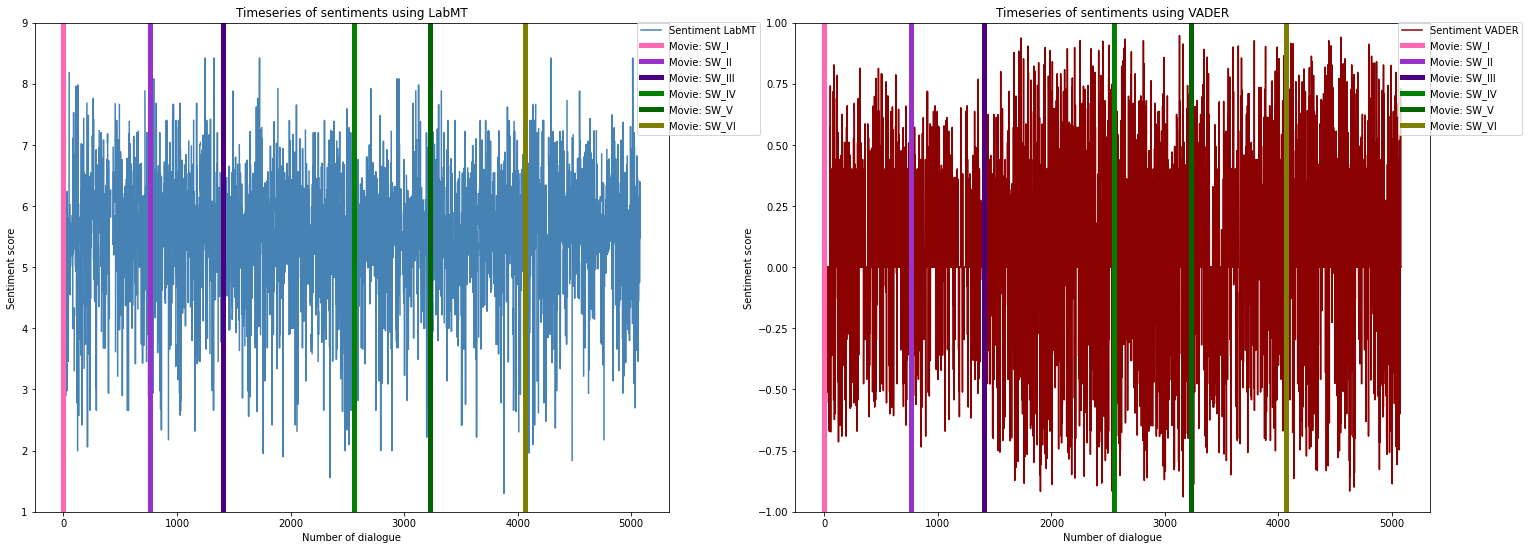

In [ ]:
# Plot sentiment as timeseries
figure(figsize = (25,9))
ax = plt.subplot(1,2,1)
plt.plot(SW_script_df.index, SW_script_df['Sentiment_LabMT'], label = 'Sentiment LabMT', color='steelblue')
plt.ylim([1,9])
plt.ylabel('Sentiment score')
plt.xlabel('Number of dialogue')
plt.title('Timeseries of sentiments using LabMT')
# Add the movie indications 
for i,j,c in zip(index_All, movies_index, color_movie):
    plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
plt.legend(loc=(0.95,0.77))


ax2 = plt.subplot(1,2,2)
plt.plot(SW_script_df.index, SW_script_df['Sentiment_VADER'], color='darkred', label = 'Sentiment VADER')
plt.ylim([-1,1])
plt.ylabel('Sentiment score')
plt.xlabel('Number of dialogue')
plt.title('Timeseries of sentiments using VADER')
# Add the movie indications 
for i,j,c in zip(index_All, movies_index, color_movie):
    plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
plt.legend(loc=(0.95,0.77))

plt.show()

We have plotted the sentiment scores as a time series based on when the dialogue appears in all the movies. This plot is created in the chronological order meaning the prequal movies comes before the original movies. Form the plot we see that the sentiment varies a lot. We cannot see any clear indications of large period of time where characters are happy or sad.

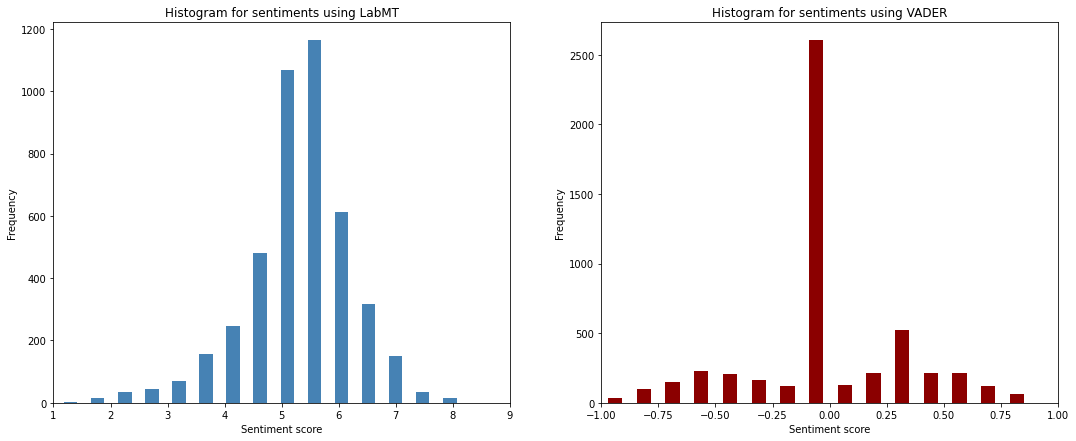

In [ ]:
# Plot distirubtion of sentiment 
figure(figsize = (18,7))
plt.subplot(1,2,1)
plt.hist(SW_script_df['Sentiment_LabMT'], bins=15, align='left', rwidth = 0.5, color='steelblue')
plt.title('Histogram for sentiments using LabMT')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([1,9])

plt.subplot(1,2,2)
plt.hist(SW_script_df['Sentiment_VADER'], bins=15, align='left', rwidth = 0.5, color='darkred')
plt.title('Histogram for sentiments using VADER')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([-1,1])

plt.show()

Above we have the distribution plot for the sentiment using the two methods. We see that for both methods we have score across the whole range, but for both methods majority of the dialogues are categorized as neutral.

#### Character based analysis
We will take a look at the average sentiment for characters with the highes amount of dialogues. 

In [ ]:
SW_script_df.groupby('Character').agg({'Dialogue': 'count', 'Sentiment_LabMT':'mean', 'Sentiment_VADER':'mean'})\
    .sort_values('Dialogue', ascending=False).head(10)

,Dialogue,Sentiment_LabMT,Sentiment_VADER
Character,,,
ANAKIN,595,5.512924,0.043821
LUKE,494,5.522144,0.056700
HAN,459,5.617464,0.106785
OBI-WAN,406,5.506546,0.022793
THREEPIO,306,5.387646,0.056952
PADME,266,5.582785,0.051989
LEIA,227,5.485728,0.045899
YODA,148,5.441334,0.030941
QUI-GON,142,5.564141,0.060327


We can see the top 10 characters with most dialogues for both methods have an average sentiment of around 5 and 0 respectively to LabMT and VADER, which are categorized as neutral.

To take a detailed look into characters timeseries plot for sentiment, we will start with defining the function for plotting the timeseries based on a given character. 

In [ ]:
def time_sentiment(df, name_list):
    figure(figsize = (25,9))
    plt.subplot(1,2,1)

    # Plot for LabMT
    sns.set_palette("Set1")
    for name in name_list:
        df_temp = df[df['Character'] == name]
        plt.plot(df_temp.index, df_temp['Sentiment_LabMT'], label = name)
    # Add the movie indications 
    for i,j,c in zip(index_All, movies_index, color_movie):
        plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
    plt.legend(loc=(0.95,0.77))
    plt.ylabel('Sentiment score')
    plt.xlabel('Number of dialogue')
    plt.ylim([1,9])
    plt.title('Timeseries of sentiments for' + str(name_list) + 'using LabMT')

    plt.subplot(1,2,2)
    # Plot for VADER
    sns.set_palette("Set2")
    for name in name_list:
        df_temp = df[df['Character'] == name]
        plt.plot(df_temp.index, df_temp['Sentiment_VADER'], label = name)
    # Add the movie indications 
    for i,j,c in zip(index_All, movies_index, color_movie):
        plt.axvline(x=i, label='Movie: {}'.format(j), c=c, lw=5)
    plt.legend(loc=(0.95,0.77))
    plt.ylim([-1,1])
    plt.ylabel('Sentiment score')
    plt.xlabel('Number of dialogue')
    plt.title('Timeseries of sentiments for ' + str(name_list) + ' using VADER')

    plt.show()

From the word cloud we found that Anakin Skywalker (Darth Vader) had an interesting shift in the type of word occurring based on the movies. We will see if we can see a similar tendency in the sentiment based on the dialogues spoken by him. Additionaly, as previously mentioned he shifts form the light side to the dark side, thus we whish to see if this can be seen in the sentiment. 

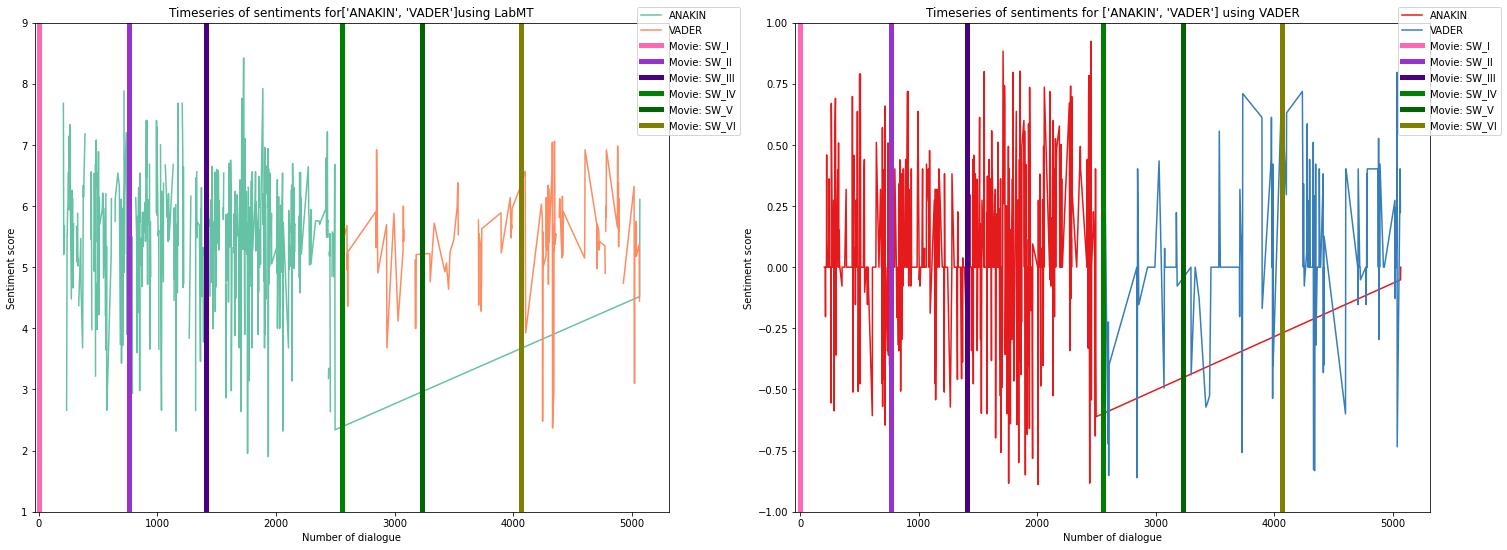

In [ ]:
time_sentiment(SW_script_df, ['ANAKIN','VADER'])

From the plot above we see on the left-hand side, that there is no clear tendency using LabMT. For the VADER plot on the right, we see that in the second movie Anakin in the beginning primarily have a more positive sentiment. From the world clouds in section 4.2 positive words occurs such as 'alive' and 'laughing'. We know form the movies that he is in love at that time. 

But from the plot we also see a tendency towards positive in the second half of the third movie. From watching the movie, we know that this is where he is questioning himself and turning to the dark side. This contradicts with the sentiment, since you would imagine someone in question of his existence will not use a lot of words which are positive. This could also mean that the reason for the positive tendency in the second movie could be a coincidence. 

We will look at Yoda's sentiment timeseries plot to see if the sentiment also varies.

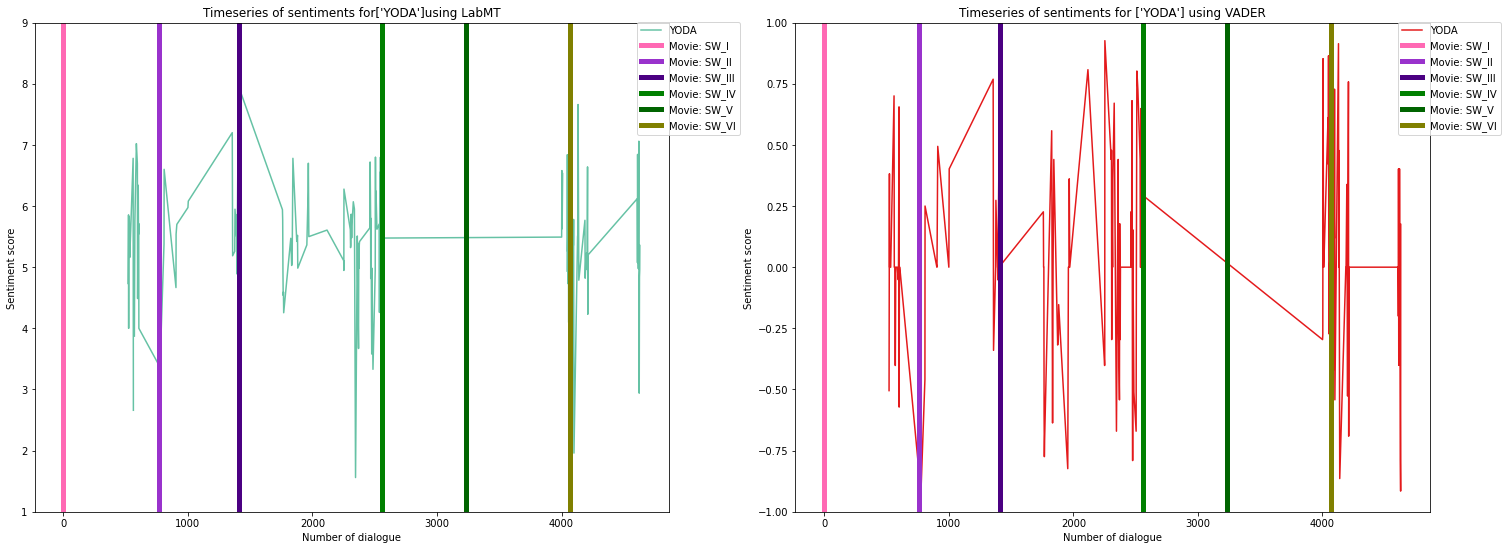

In [ ]:
time_sentiment(SW_script_df, ['YODA'])

From the plot for Yoda, we again see that there are a lot of variation in the tendency which is unexpected, since Yoda is supposed to be a wise character. Additionally, as a jedi you are supposed to be neutral. These traits can not be seen in plot.  

From the sentiment analysis we found that the sentiment for the dialogues varies a lot. The sentiment analysis on the Star Wars scripts are not informative. We cannot see any overall tendency for the movies or characters based on the scripts. One of the reasons for this conclusion could be because the scripts are only part of a movie. How an actor acts out the dialogue will largely affect how the viewer perceive the emotions. If a character cries while saying 'I am happy' in the sentiment analysis will categorized it as being positive, but in reality, the actor and the screen is trying to express a sad emotion. The movie scripts are only a small part of expressing the emotions of characters, and thus if we wish to analysis the emotions characters are expressing, we need to take more into account than solely the dialogues.

## Part 3.6: Hidden topic modeling
<a id='htm.'></a> 

Here we'll apply hidden topic modeling to two different corpuses and see how the topics are related to the documents.

We'll use the Latent Dirichlet Allocation (LDA) model which is an unsuperviced machine learning model, thus no previous labelling has to be made, and we only have to provide our corpus.

### Part 3.6.1: Movie Scipts
<a id='htm_script.'></a> 

For this part we'll use the txt files generated in ?!?!?!?!?

We examine if the hidden topic modelling can detect 6 different topics (hidden topics = 6) for the 6 different movies. 

Thus we initialize by creating a corpus of the scripts for every movie. We reuse the data frames for the scripts defined in previous parts.

In [ ]:
list_of_scripts = [re.split(' ',' '.join([' '.join(i) for i in sw1_df['clean_text'].values])),
re.split(' ',' '.join([' '.join(i) for i in sw2_df['clean_text'].values])),
re.split(' ',' '.join([' '.join(i) for i in sw3_df['clean_text'].values])),
re.split(' ',' '.join([' '.join(i) for i in star_wars_IV_df1['Dialogue'].values])),
re.split(' ',' '.join([' '.join(i) for i in star_wars_V_df1['Dialogue'].values])),
re.split(' ',' '.join([' '.join(i) for i in star_wars_VI_df1['Dialogue'].values]))]

With this we just need to build a dictionary with `corpora.Dictionary` which we can then use to map it to an index acordingly with `id2word.doc2bow`

In [ ]:
id2word = corpora.Dictionary(list_of_scripts) # creating dictionary

common_corpus = [id2word.doc2bow(index) for index in list_of_scripts] # maping to index

model = gensim.models.LdaModel(corpus = common_corpus, id2word = id2word, num_topics = 6, chunksize = 1, random_state = 3) #building model
model.show_topics(num_topics=6, num_words = 8) # printing out the words for the topics

[(0,
  '0.005*"rebel" + 0.005*"chewie" + 0.004*"look" + 0.004*"imperial" + 0.004*"princess" + 0.004*"uncle" + 0.004*"think" + 0.003*"okay"'),
 (1,
  '0.032*"chewie" + 0.015*"jabba" + 0.014*"solo" + 0.010*"rebel" + 0.008*"princess" + 0.007*"imperial" + 0.006*"destiny" + 0.006*"lando"'),
 (2,
  '0.007*"jedi" + 0.006*"master" + 0.005*"anakin" + 0.005*"know" + 0.004*"must" + 0.004*"chancellor" + 0.003*"artoo" + 0.003*"right"'),
 (3,
  '0.008*"jedi" + 0.007*"back" + 0.007*"luke" + 0.006*"anakin" + 0.006*"think" + 0.006*"master" + 0.006*"time" + 0.006*"take"'),
 (4,
  '0.021*"father" + 0.015*"dark" + 0.008*"might" + 0.007*"done" + 0.007*"sister" + 0.007*"destroy" + 0.006*"commander" + 0.006*"easy"'),
 (5,
  '0.017*"luke" + 0.011*"good" + 0.010*"take" + 0.009*"must" + 0.009*"could" + 0.008*"time" + 0.008*"back" + 0.008*"vader"')]

With this topic modelling we see some clear topic-movie correlation. For topic 0 we have 'princess' and 'uncle' which are specific to the 4th movie. For topic 4 we see 'father' and 'sister' which is also specific to movie 6. But we there are also problems, looking at topic 3 Luke and Anaking are only mentioned together in the 6th movie, but we already assigned topic 4 to movie 6. Additionaly the words have small weight and are thus not descriptive of the topic. 

When mapping the topics with PCA we also see this problem:

In [ ]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
temp = pyLDAvis.gensim_models.prepare(topic_model=model, corpus=common_corpus, dictionary=id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(temp)

Here topic 5 (in the plot) corrosponds to topic 0 (in our model print), and we see that this topic is neglegeble in size. Topic 1 (plot) corrosponds to topic 5 (print output) and given it's large size and the fact that it contains words like (Luke, Vader, Emporer, Leia, Force etc.) it most likely describes the entire original trilogy (movies 4-6). 

The fact that LDA does not capture all 6 movies and just the generel themes is likely due to two reasons. 
1) It's an unsupervised model and thus the result will differ everytime, which is why we set the random_state. This also means it's probably possible to create 6 clearly different topics for the 6 movies, but statistically it will be unlikely because

2) the movies are very similar. They are all from the same cinematic universe and movies 4 and 6 had the same plot of destroying the death star. Additionaly, the main characters are the same in the sequal, and in the prequals.

This is why we'll also look at choosing 2 hidden topics instead (one for each trilogy):

In [ ]:
model = gensim.models.LdaModel(corpus = common_corpus, id2word = id2word, num_topics = 2, chunksize = 1, random_state = 5) #building model
model.show_topics(num_topics=2, num_words = 8) # printing out the words for the topics

[(0,
  '0.012*"luke" + 0.009*"good" + 0.008*"take" + 0.007*"must" + 0.007*"time" + 0.007*"vader" + 0.007*"back" + 0.006*"could"'),
 (1,
  '0.012*"chewie" + 0.008*"look" + 0.007*"luke" + 0.006*"father" + 0.006*"ship" + 0.006*"jabba" + 0.006*"think" + 0.006*"take"')]

Luke, father, and Chewie are from the sequals, thus the hidden topic modeling is still not capturing prequals/sequals. 

Finally, we'll do a hidden topic analyses for each movie sepperately:

In [ ]:
i = 1

for movie in list_of_scripts:
    id2word = corpora.Dictionary([movie]) # creating dictionary

    common_corpus = [id2word.doc2bow(index) for index in [movie]] # maping to index

    model = gensim.models.LdaModel(corpus = common_corpus, id2word = id2word, num_topics = 1) #building model
    print(f'Movie: {i}')
    print(f'{model.show_topics(num_topics=1, num_words = 6)}\n') # printing out the words for the topics
    i += 1

Movie: 1
[(0, '0.009*"think" + 0.008*"master" + 0.007*"take" + 0.007*"know" + 0.007*"mesa" + 0.007*"queen"')]

Movie: 2
[(0, '0.016*"master" + 0.016*"geonosis" + 0.015*"jedi" + 0.011*"night" + 0.010*"anakin" + 0.009*"naboo"')]

Movie: 3
[(0, '0.019*"jedi" + 0.016*"anakin" + 0.012*"master" + 0.011*"chancellor" + 0.010*"know" + 0.008*"right"')]

Movie: 4
[(0, '0.012*"luke" + 0.008*"ship" + 0.007*"think" + 0.007*"look" + 0.006*"back" + 0.006*"time"')]

Movie: 5
[(0, '0.008*"good" + 0.008*"luke" + 0.007*"lord" + 0.007*"ship" + 0.007*"chewie" + 0.007*"vader"')]

Movie: 6
[(0, '0.012*"luke" + 0.009*"father" + 0.009*"chewie" + 0.008*"good" + 0.007*"take" + 0.006*"back"')]



Unsuprisngly the topic modelling better captures the plot of the movies. Geonosis a planet important to the second movie, and 'Mesa' Jar-Jar's catchphrase from the first movie. However, we still se the topics for movies 1 and 5 are undescriptive given their low word score.